In [15]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
from astropy.constants import c
from scipy.fftpack import fft, fftfreq, ifft, rfftfreq
c = c.value*1e-6 #Speed of light in mm/ns

In [2]:
ydatadir = '../data/15-02 95GHz Ypol/'
yfiles = glob(ydatadir + 'fts_95GHz_20160425_0*.txt') 
xdatadir = '../data/15-02 95GHz Xpol/'
xfiles = glob(xdatadir + 'fts_95GHz_20160425_0*.txt')
files = yfiles + xfiles
myfilter = '15-02'
freq = '95GHz'
L = 1.75*25.4 # thickness of the etalon in mm
# print files

In [3]:
def quadratic(x, A, B, C):
    return A*x**2 + B*x + C

In [11]:
spectra = []
rspectra = []
ispectra = []
freqs = []
for f in files:
    index, time, encoder, signal = np.loadtxt(f, comments='#', skiprows=21, unpack=True)
    
    # Find the right position of the origin of the interferogram
    peak = np.where(signal == max(signal))[0][0]
    y = signal[peak-1: peak+2]
    x = encoder[peak-1:peak+2]
    X = np.vstack([x**2, x, np.ones_like(x)]).T
    A = np.linalg.solve(X, y)
    actual_peak = -A[1]/(2*A[0])
    sig_peak = quadratic(actual_peak, *list(A))
    encoder -= actual_peak
    encoder *=2 # Encoder now represents the path length difference
    
#     peak = encoder[np.where(signal == max(signal))[0]][0]
#     thresh = np.logical_and(encoder > (peak - 1.0), encoder < (peak + 1.0))
#     encoder = encoder[thresh]
#     signal = signal[thresh]

    #Let's try out I(z) - I(0)/2
    signal -= sig_peak/2
    
    # Remove the dc component as much as we can
    mean = np.average(signal)
    signal -= mean
    
    y = fft(signal)
    d = np.mean(np.diff(encoder))
#     print d
    n = len(encoder)
    k = fftfreq(n,d)*c
    spectra += [y]
    rspectra += [np.real(y)]
    ispectra += [np.imag(y)]
    freqs += [k]
spectra = np.array(spectra)
rspectra = np.array(rspectra)
ispectra = np.array(ispectra)
freqs = np.array(freqs)

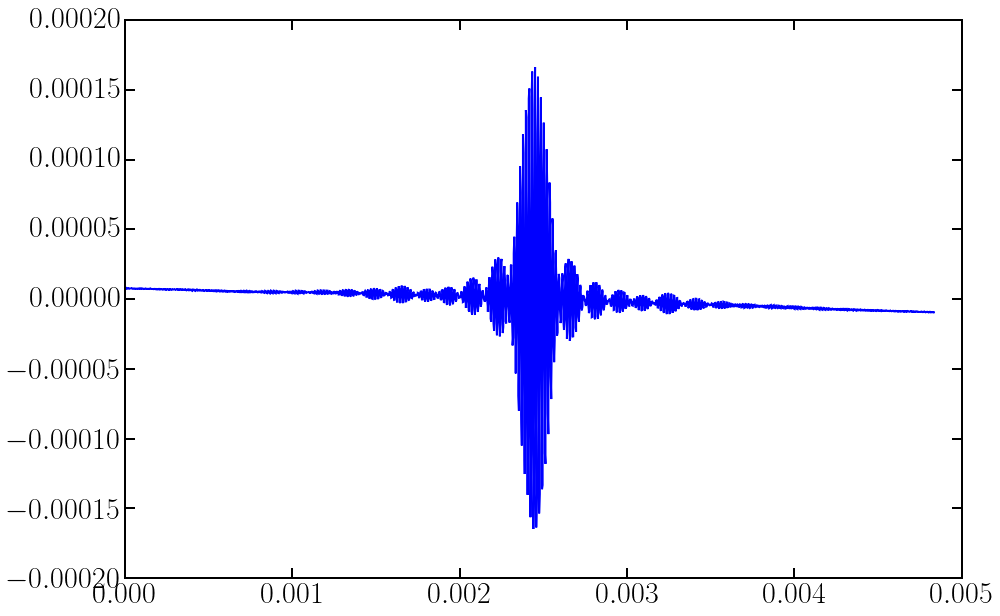

In [16]:
autocorr = ifft(spectra[0])
x = rfftfreq(n, k[1]-k[0])/c

fig, ax =plt.subplots(figsize=(15,10))
ax.plot(x, np.real(autocorr))

In [7]:
ypol = np.arange(0, 9)
xpol = np.arange(9, 18)

In [8]:
# Average out our spectra to reduce the noise
pol = ypol
code = 'y'#'x'
rnosample = np.average(rspectra[pol][::2], axis=0)
rnosampleerr = np.std(rspectra[pol][::2], axis=0)
inosample = np.average(ispectra[pol][::2], axis=0)
inosampleerr = np.std(ispectra[pol][::2], axis=0)

rsample = np.average(rspectra[pol][1::2], axis=0)
rsampleerr = np.std(rspectra[pol][1::2], axis=0)
isample = np.average(ispectra[pol][::2], axis=0)
isampleerr = np.std(ispectra[pol][::2], axis=0)

k = np.average(freqs[pol], axis=0)
kerr = np.std(freqs[pol], axis=0)

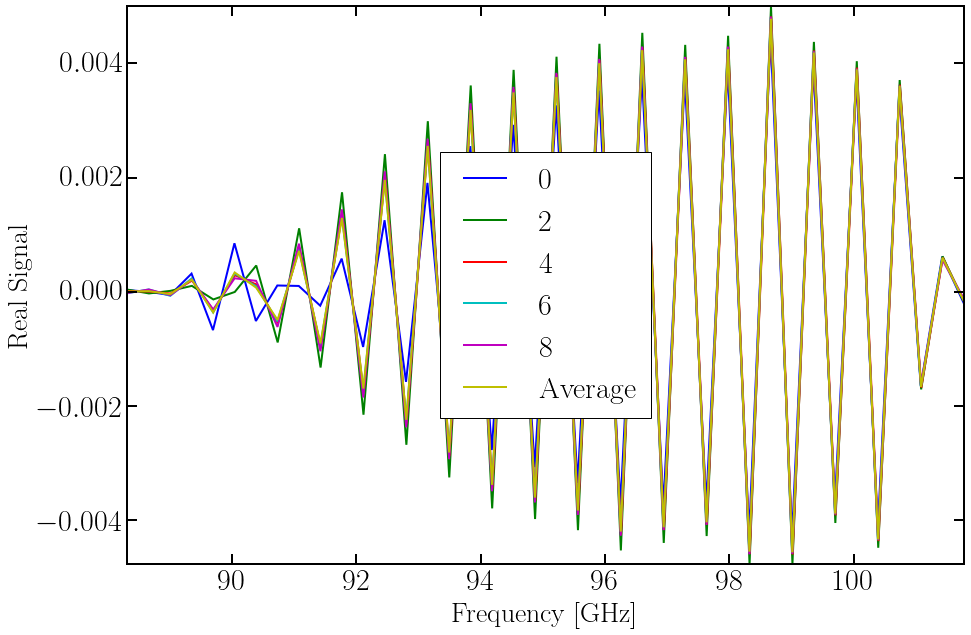

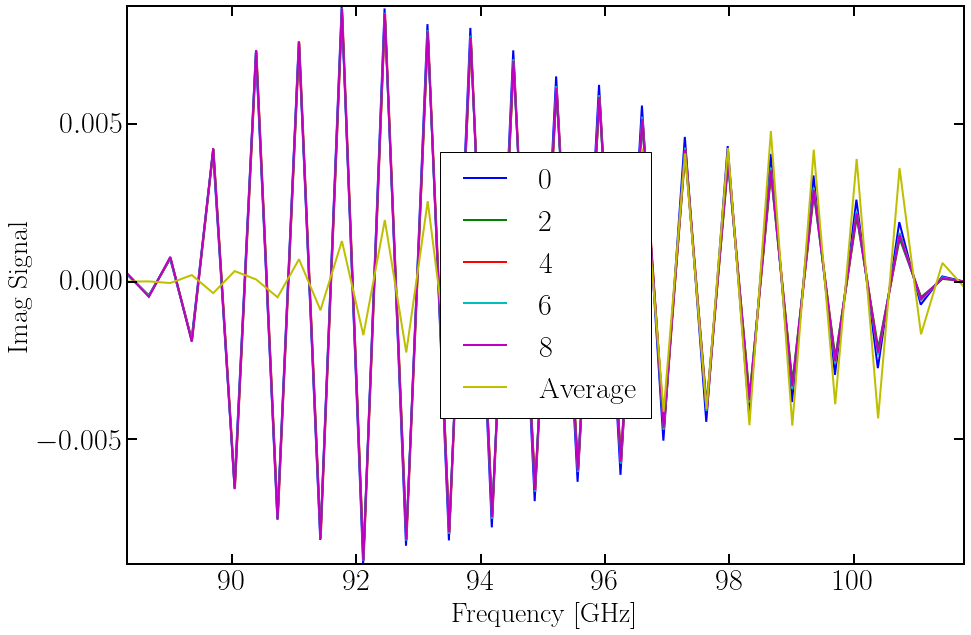

In [10]:
fig, ax = plt.subplots(figsize=(15,10))
# thresh = np.logical_and(k > 138, k < 160)
thresh = np.logical_and(k > 88, k < 102)
mask = np.ones(10)
for i in xrange(pol[0], pol[-1]+1,2):
    ax.plot(freqs[i][thresh], rspectra[i][thresh], label='%d'%i)
#     ax.plot(freqs[i][thresh], phase[i][thresh])
ax.plot(k[thresh], rnosample[thresh], label='Average');
ax.legend(loc='best')
ax.axis('tight');
ax.set_xlabel('Frequency [GHz]');
ax.set_ylabel('Real Signal');
plt.savefig('real.png')

fig, ax = plt.subplots(figsize=(15,10))
for i in xrange(pol[0], pol[-1]+1,2):
    ax.plot(freqs[i][thresh], ispectra[i][thresh], label='%d'%i)
#     ax.plot(freqs[i][thresh], phase[i][thresh])
ax.plot(k[thresh], rnosample[thresh], label='Average');
ax.legend(loc='best')
ax.axis('tight');
ax.set_xlabel('Frequency [GHz]');
ax.set_ylabel('Imag Signal');
plt.savefig('imaginary.png')

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
# thresh = np.logical_and(k > 138, k < 160)
# thresh = np.logical_and(k > 90, k < 100)
mask = np.ones(10)
for i in xrange(pol[0], pol[-1]+1,2):
    realsig = spectra[i]*np.cos(phase[i])
    ax.plot(freqs[i][thresh], realsig[thresh], label='%d'%i)
#     ax.plot(freqs[i][thresh], phase[i][thresh])
ax.plot(k[thresh], (nosample*np.cos(nosamplephase))[thresh], label='Average');
ax.legend(loc='best')
ax.axis('tight');
ax.set_xlabel('Frequency [GHz]');
ax.set_ylabel(' Real Signal');

fig, ax = plt.subplots(figsize=(15,10))
for i in xrange(pol[0], pol[-1]+1,2):
    imsig = spectra[i]*np.sin(phase[i])
    ax.plot(freqs[i][thresh], imsig[thresh], label='%d'%i)
#     ax.plot(freqs[i][thresh], phase[i][thresh])
ax.plot(k[thresh], (nosample*np.sin(nosamplephase))[thresh], label='Average');
ax.legend(loc='best')
ax.axis('tight');
ax.set_xlabel('Frequency [GHz]');
ax.set_ylabel('Imaginary Signal');

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
# thresh = np.logical_and(k > 140, k < 160)
ax.plot(k[thresh], nosample[thresh],'k', label='Reference Spectra');
ax.plot(k[thresh], sample[thresh],'r', label='Sample Spectra');
ax.axis('tight');
ax.legend(loc='best')
ax.set_xlabel('Frequency, GHz');
plt.savefig(freq + myfilter + code +'polspectra.png')

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
# thresh = np.logical_and(k > 140, k < 160)
ax.plot(k[thresh], (nosample*np.cos(nosamplephase))[thresh],'k', label='Reference Spectra');
ax.plot(k[thresh], (sample*np.cos(samplephase))[thresh],'r', label='Sample Spectra');
ax.axis('tight');
ax.legend(loc='best')
ax.set_xlabel('Frequency, GHz');
plt.savefig(freq + myfilter + code +'polrealspectra.png')

In [ ]:
transmission = sample/nosample
scaled_spectrum = nosample/max(nosample)
kthresh = np.logical_and(k > 80, k < 110)
t_err = transmission * np.sqrt((sampleerr/sample)**2 + (nosampleerr/nosample)**2)
fig, ax =plt.subplots(figsize=(15,10))
ax.errorbar(k[kthresh], transmission[kthresh], yerr = t_err[kthresh], fmt = 'b-o', ecolor='r')
# ax.plot(k[thresh], scaled_spectrum[thresh], 'k--')
ax.grid(which='major')
ax.set_xlabel('Frequency, GHz');
ax.set_ylabel('ratio')
ax.axis('tight');
ax.set_ylim([0.8, 1.2])
plt.savefig(freq + myfilter + code + 'poltransmissionlarge.png')

In [ ]:
transmission = (sample*np.cos(samplephase))/(nosample*np.cos(nosamplephase))
# scaled_spectrum = nosample/max(nosample)
t_err = transmission * np.sqrt((sampleerr/sample)**2 + (nosampleerr/nosample)**2)
fig, ax =plt.subplots(figsize=(15,10))
ax.errorbar(k[kthresh], transmission[kthresh], yerr = t_err[kthresh], fmt = 'b-o', ecolor='r')
# ax.plot(k[thresh], scaled_spectrum[thresh], 'k--')
ax.grid(which='major')
ax.set_xlabel('Frequency, GHz');
ax.set_ylabel('Real Ratio')
ax.axis('tight');
ax.set_ylim([0.8, 1.2])
plt.savefig(freq + myfilter + code + 'polrealtransmission.png')

In [ ]:
#Let's try some interpolation
from scipy import interpolate
f = interpolate.interp1d(k[thresh], transmission[thresh], 'cubic')
kmin = k[thresh][0]
kmax = k[thresh][-1]
k_new = np.r_[kmin:kmax:2*len(k)*1j]
t_new = f(k_new)

In [ ]:
fig, ax =plt.subplots(figsize=(15,10))
ax.plot(k_new, t_new,'r', label= 'interpolated FP spectrum')
# ax.errorbar(k[thresh], transmission[thresh], yerr = t_err[thresh], color = 'b')
ax.grid(which='major')
ax.set_xlabel('Frequency, GHz');
ax.set_ylabel('Transmission')
ax.axis('tight');
from peakdetect import peakdetect
max_peaks, min_peaks = peakdetect(t_new, k_new)
loc, val = map(list, zip(*max_peaks))
ax.plot(loc, val, 'bd', markersize=5, label='peaks');
ax.legend(loc='best');
plt.savefig(freq + myfilter + code + 'polinterpolated.png')

In [ ]:
# absorption = 1 - np.array(val)
# fig, ax =plt.subplots(figsize=(15,10))
# ax.plot(loc, absorption,'r.', markersize=10);
# f = interpolate.interp1d(loc, absorption, 'cubic')
# loc_new = np.r_[loc[0]:loc[-1]:2*len(loc)*1j]
# absorption_new = f(loc_new)
# ax.plot(loc_new, absorption_new,'b');
# ax.axis('tight');

In [ ]:
from scipy.optimize import curve_fit

def get_transmission(nu, y, F, A, B):
    return y*(1 - F * (1 - np.cos(A*nu + B))/2)

R = 0.00207
F = 4*R/(1-R)**2
A = 4*np.pi*L/c
B = np.pi
y = np.average(val)
print y
guesses = [y, F, A, B]
popt, pcov = curve_fit(get_transmission, k[thresh], transmission[thresh], p0=guesses, sigma=t_err[thresh])
# popt, pcov = curve_fit(get_transmission, k_new, t_new, p0=guesses)
perr =np.sqrt(np.diag(pcov))
print popt, perr

In [ ]:
fig, ax =plt.subplots(figsize=(15,10))
ax.plot(k[thresh], transmission[thresh], 'r-+', markersize=10)
# ax.plot(k_new, t_new,'r', label='interpolated data')
# ax.errorbar(k[thresh], transmission[thresh], yerr = t_err[thresh], fmt = 'r-o',label='data')
ax.plot(k_new, get_transmission(k_new, *popt), 'b', label='fit')
# ax.plot(k[thresh], get_transmission(k[thresh], *popt), 'b', label='fit')
ax.grid(which='major')
ax.set_xlabel('Frequency, GHz');
ax.set_ylabel('Transmission')
ax.axis('tight');
ax.legend(loc='best');
plt.savefig(freq + myfilter + code + 'polinterpolatedfit.png')

In [ ]:
y, F, a, b = popt[0], popt[1], popt[2], popt[3]
sigy, sigF, siga, sigb = perr[0], perr[1], perr[2], perr[3]

In [ ]:
A = (1 - F/4)*(1 - np.sqrt(y))
T = (1 - F/4)*(np.sqrt(y))

In [ ]:
sigA = A*np.sqrt((sigy/(2*y**0.5*(1-y**0.5)))**2 + (sigF/(4*(1-F/4)))**2)
sigT = T*np.sqrt((sigy/(2*y))**2 + (sigF/(4*(1-F/4)))**2)

In [ ]:
print A, sigA
print T, sigT

In [ ]:
R = (2 + F - 2*(1+F)**0.5)/F
sigR = R/(F*(1+F)**0.5)*sigF
print R, sigR
R = 1-(T+A)
print R

In [ ]:
print np.array(files)[ypol][1::2]

In [ ]:
pol

In [ ]:
np.array(files)[ypol[::2]]

In [ ]:
fig, ax =plt.subplots(figsize=(15,10))
for i in xrange(5):
    ax.plot(freqs[ypol][::2][i][thresh], label='%d'%i)
ax.legend(loc='best')

In [ ]:
freqs[ypol][::2][3][10] - freqs[ypol][::2][0][10]

In [ ]:
range(pol[1], pol[-1]+1,2)

In [ ]:
xpol

In [ ]:
range(pol[0], pol[-1]+1,2)

In [ ]:
np.array(files)[ypol]

In [ ]:
range(1,9)[1::2]

In [ ]:
k[0]

In [ ]:
k[-1]

In [ ]:
k[1816]

In [ ]:
c/(2*L)

In [ ]:
np.array(files)[pol]